# Cálculo Numérico &mdash; Decomposição LU

**Professor**: Luiz Gustavo Cordeiro

Uma *decomposição LU* de uma matriz quadrada $A$ é um par $(L,U)$ de matrizes triangulares (quadradadas de mesma ordem que $A$) tais que
- $A=LU$
- $L$ é triangular inferior (*lower triangular*)
- $U$ é triangular superior (*upper triangular*)

Existem matrizes que não admitem decomposições LU, e mesmo no caso em que uma tal decomposição exista, ela não é única. Porém, a classe de matrizes que admitem decomposições LU é relativamente grande, e para alguns tipos de problemas específicos os processos númericos podem ter sua eficiência aumentada com o uso de uma decomposição LU.

## Algoritmo de Crout para a calcular uma decomposição LU de uma matriz.

O algoritmo de Crout é o algoritmo mais simples que permite calcular a decomposição LU de uma matriz. Existe alguma liberdade no algoritmo, no sentido de que ele pede (em várias iterações em alguns laços) por uma "escolha de número $l$ e $u$ tais que o produto $l\cdot u$ é um certo número". Abaixo, utilizamos a implementação conhecida como *Algoritmo de Crout&ndash;Dolittle*.

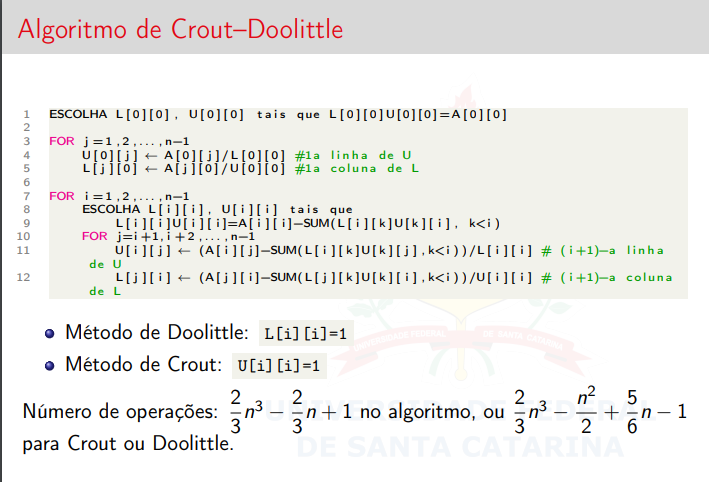

In [3]:
import numpy as np

In [2]:
def crout_dolittle(A):
    ''' Decomposição LU de A pelo algoritmo de Crout'''

    m,n = np.shape(A) # pega as dimenções

    L = np.zeros((n,n)) # cria matriz de zeros
    U = np.zeros((n,n))

    L[0,0] = 1          # Escolha de Dolittle
    U[0,0] = A[0,0]

    for j in range(1,n):
        U[0,j] = A[0,j]/L[0,0]      # Determina a primeira linha de U
        L[j,0] = A[j,0]/U[0,0]      # Determina a primeira coluna de L
        # op+=2
    for i in range(1,n):
        L[i,i]=1        # Escolha de Dolittle
        U[i,i] = A[i,i] - sum([L[i,k]*U[k,i] for k in range(i)])
        
        for j in range(i+1,n):
            U[i,j] = (A[i,j] - sum([L[i,k]*U[k,j] for k in range(i)]))/L[i,i]       # Determina a i-ésima linha de U
            L[j,i] = (A[j][i] - sum([L[j,k]*U[k,i] for k in range(i)]))/U[i,i]      # Determina a i-ésima coluna de L

    return L , U

Para testar o algoritmo acima, basta:

1. Criar uma matriz aleatória $A$.
2. Aplicar o algoritmo acima em $A$ e receber duas novas matrizes $L$ e $U$.
3. Verificar se $LU = A$.

Espera-se que o passo 3 nos dê uma resposta positiva.

In [3]:
A = 20*np.random.rand(4,4) - 10.0       # Matriz aleatória com entradas entre -10 e 10

L , U = crout_dolittle(A)               # Decomposição LU de $A$

print(f"A matriz A é dada por\n{A}")
print(f"\nA matriz L é dada por\n{L}")
print(f"\nA matriz U é dada por\n{U}")
print(f"\n\nO produto LU é dado por\n{L@U}")

A matriz A é dada por
[[ 7.82991524 -7.99648291  5.27668493 -5.0405628 ]
 [-8.71292939  6.09900299 -8.30414052 -2.033339  ]
 [-6.8320896   0.72139064 -8.02840851 -1.46391667]
 [ 4.2865825   0.08016255 -0.82707838  1.94525786]]

A matriz L é dada por
[[ 1.          0.          0.          0.        ]
 [-1.11277442  1.          0.          0.        ]
 [-0.8725624   2.23487564  1.          0.        ]
 [ 0.54746218 -1.59252976 -3.77231285  1.        ]]

A matriz U é dada por
[[ 7.82991524 -7.99648291  5.27668493 -5.0405628 ]
 [ 0.         -2.79927864 -2.43238051 -7.64234835]
 [ 0.          0.          2.01189628 11.21757594]
 [ 0.          0.          0.         34.85031403]]


O produto LU é dado por
[[ 7.82991524 -7.99648291  5.27668493 -5.0405628 ]
 [-8.71292939  6.09900299 -8.30414052 -2.033339  ]
 [-6.8320896   0.72139064 -8.02840851 -1.46391667]
 [ 4.2865825   0.08016255 -0.82707838  1.94525786]]


Note que, de fato, as matrizes $L$ e $U$ são triangulares inferior e superior, respectivamente, e que o produto $LU$ iguala a matriz $A$ (talvez dentro de uma pequena tolerância).

## Aplicação da decomposição LU

Em essência, o processo de retrossubstituição resolve um sistema linear triangular superior, com $O(n^2)$ operações. Ele pode ser adaptado &ndash; sem muitas dificuldades &ndash; para um processo que resolva um sistema triangular inferior com $O(n^2)$ operações (que eu costumo chamar de *substituição progressiva*).

Suponha que uma matriz $A$ possui uma decomposição $LU$. Por exemplo, o algoritmo de Crout acima calcula essa decomposição com $O(n^3)$ operações. Se tivermos um sistema linear
$$Ax=b,$$
ele se transforma num sistema
$$LUx = b.$$
Fazendo a substituição
$$Ux=y,$$
chegamos num par de sistemas lineares
$$\begin{cases}Ly=b,\\Ux=y,\end{cases}$$
que podem ser resolvidos em sequência para para calcular $y$ (com o primeiro sistema linear) e depois $x$ (com o segundo). Isso nos dá um método de calcular $x$ com $2O(n^2)=O(n^2)$ operações.

In [4]:
def solve_triangular_superior(U, b):
    """Resolve um sistema triangular superior do tipo Ux = b.

    Parametros obrigatorios
    ----------
    U : Array-like de dimensao 2
        Matriz quadrada triangular superior inversível

    b : Array-like de dimensão 1
        Vetor independente

    Saída
    ----------
    x : Array-like de dimensão 1
        Solução do sistema Ux = b"""
    
    n = U.shape[0]          # Ordem das matrizes
    
    # Cópias usuais para evitar problemas
    x = b.copy().reshape(n)

    # Vai linha-a-linha, de ***baixo para cima***, escalonando a matriz utilizando o pivô na diagonal
                        
    for i in range(n-1,-1,-1):
        x[i] /= U[i,i]     # Normaliza a i-ésima linha
        for j in range(i-1,-1,-1):
            x[j] -= U[j,i]*x[i]     # Pivoteia a i-ésima coluna, utilizando a entrada diagonal como pivô

    return x

Para testar essa função, vamos criar uma matriz triangular superior $U$ e um vetor $b$ aleatórios, e verificar se o retorno $x$ dessa função satisfaz $Ux=b$.

In [5]:
U = 20*np.random.rand(4,4) -10 # Matriz triangular aleatória com entradas em [-10,10]

for i in range(4):
    for j in range(i):
        U[i,j]=0.0        # Aniquila as entradas abaixo da diagonal principal para deixar triangular superior
        
        
b = 20*np.random.rand(4) - 10 # Vetor aleatório com entradas em [-10,10]
operacoesU=0
x = solve_triangular_superior(U,b,operacoesU) # Solução pretendida do sistema Ux = b

print(f"\nA matriz U é dada por\n{U}")
print(f"\nO vetor b é dada por\n{b}")
print(f"\nO vetor x é dada por\n{x}")
print(f"\nO vetor Ux é dada por\n{U@x}")
print(f"\nO numero de operações de uma matriz 4x4 é: \n{operacoesU}")



A matriz U é dada por
[[ 1.34002307  3.56339309  9.697543   -0.40978346]
 [ 0.          5.25054784  6.43090169  7.9874477 ]
 [ 0.          0.          5.81495186  3.23158572]
 [ 0.          0.          0.         -5.65969233]]

O vetor b é dada por
[ 9.49748819 -9.3812667  -1.8507873  -3.17072105]

O vetor x é dada por
[16.78223414 -1.8678116  -0.62962065  0.56022852]

O vetor Ux é dada por
[ 9.49748819 -9.3812667  -1.8507873  -3.17072105]


> **Atividade** (Sendo aprimorada):
> 1. Adapte o código acima para fazer com que a função `solve_triangular_inferior()` também retorno o número de operações (somas, produtos, divisões e subtrações numéricas) que foram realizadas. (**Dica**: A resposta é $n^2$; tente deduzir este valor formalmente).
> 2. Adapte o código acima para fazer o processo análogo (também contando operações), mas com matrizes triangulares _inferiores_.
> 3. Adapte o algoritmo de Crout&ndash;Dolittle, para fazer com que ele também retorne o número de operações realizadas.
> 4. Utilize as funções criadas no passo anterior para criar uma função que recebe uma matriz $A$, um inteiro positivo $n$ e um vetor $b$ e
>     - Decompõe a matriz $A$ como $A=LU$.
>     - Resolve o sistema linear $A^n x = b$, com aplicações sucessivas das funções criadas nos passos 1. e 2.
>     - Conta o número de operações.
> 5. Adapte o algoritmo de resolução de sistemas lineares da aula 9 para que ele conte o número de operações realizadas.
> 6. Adapte o algoritmo abaixo, que realiza o produto de duas matrizes $A$ e $B$, para que ele também conte o número de operações realizadas.
> 7. Crie uma matriz aleatória $A$ de ordem $4\times 4$ e um vetor $b$ de tamanho $4$, e resolva o sistema $A^{20}x = b$ por dois modos:
>     - Utilizando o método do passo 4;
>     - Calculando o produto $A^{20}=A\cdot A\cdots A$ com o algoritmo do passo 6, e resolvendo o sistema $(A^n)x = b$ diretamente com o algoritmo do passo 5.
>
>     Compare os números de operações e os resultados.

# ADICIONADA POR MIM:

In [5]:
# +++++++++++++++++++++++++  QUESTÂO 01,2 ++++++++++++++++++++++++++++++++++++++


def solve_triangular_inferior(L, B,op):
    """Resolve um sistema triangular inferior do tipo Ux + B."""

    n = L.shape[0]        
    X = B.copy().reshape(n)
    # Vai linha-a-linha, de ****cima para baixo***, escalonando a matriz utilizando o pivô na diagonal
    
    for i in range(n):
        for j in range(i):
            X[i] -= L[i,j] * X[j] # Pivoteia a i-ésima coluna, utilizando a entrada diagonal como pivô
            op+=2 #1 soma, 1 multiplicação
        X[i] /= L[i,i]     # Normaliza a i-ésima linha
        op+=1
    return X, op
          
L = 20*np.random.rand(4,4) -10 
for i in range(4):
    for j in range(i):
        L[j,i]=0.0        # Aniquila as entradas acima da da diagonal principal para deixar triangular inferior
        
b = 20*np.random.rand(4) - 10 
op = 0
y,op = solve_triangular_inferior(L,b,op) # Solução pretendida do sistema Ly = x

print(f"\nA matriz L é dada por\n{L}")
print(f"\nO vetor b é dada por\n{b}")
print(f"\nO vetor y é dada por\n{y}")
print(f"\nO vetor Ly é dada por\n{L@y}")
print(f"\nO numero de operacões para uma matriz 4x4 é:\n{op}")



A matriz L é dada por
[[ 2.36589239  0.          0.          0.        ]
 [-2.37429257 -4.46060581  0.          0.        ]
 [ 7.77491126  5.47012701 -0.90983186  0.        ]
 [ 1.83299455 -2.60017821 -2.8399248   3.41037844]]

O vetor b é dada por
[ 4.22100244 -9.60898362 -6.6445184  -8.74554659]

O vetor y é dada por
[ 1.78410584  1.20454364 29.79098756 22.20292882]

O vetor Ly é dada por
[ 4.22100244 -9.60898362 -6.6445184  -8.74554659]

O numero de operacões para uma matriz 4x4 é:
16


# Fim da minha adição

In [5]:
def matmul(A,B):
    """Produto de matrizes quadradas de mesma ordem

    Parametros obrigatorios
    ----------
    A , B : Array-like de dimensao 2
        Matrizes quadradas de mesma ordem

    Saída
    ----------
    C : Array-like de dimensão 2
        Produto C = AB"""
    
    n=A.shape[0]
    print (n)
    C = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i,j] += A[i,k]*B[k,j]
                
    return C
L = 20*np.random.rand(4,4) -10 
U = 20*np.random.rand(4,4) -10 


# Algoritmo de Thomas (A ser melhorado)

In [7]:
def thomas (B,b):
    ''' Resolve Ax = b, com A tridiagonal'''

    A=B.copy()
    c = b.copy()
    # Triangularização

    p,n = np.shape(A)
    for k in range(n-1):
        m = A[k+1,k]/A[k,k]
        A[k+1,k] = 0
        A[k+1,k+1] = A[k+1,k+1] - m*A[k,k+1]
        c[k+1] = c[k+1]-m*c[k]

    #Retrossub

    x = np.zeros(n)

    for i in range(n-2,-1,-1):
        x[i] = (c[i] - A[i,i+1]*x[i+1])/A[i,i]

    return x

In [8]:
import numpy as np

A = np.array([
    [3,-1,0,0],
    [1,4,1,0,],
    [0,2,3,0],
    [0,0,2,-5]
]).astype(float)

b=np.array([2.0,-3.0,4.0,0.0])

In [9]:
x=thomas(A,b)
print(x)

[ 0.21212121 -1.36363636  2.24242424  0.        ]


In [10]:
print(A@x)
print(b)

[ 2.         -3.          4.          4.48484848]
[ 2. -3.  4.  0.]
